## Model 1b: Single-country policy simulation

The objective of this model-based simulation is to analyse the impact of policy, technology, and commodity changes on consumer price inflation in selected countries. The simulation environment is learnt from real data, after which simulations using synthetic data are used to do policy analysis by manipulating a number of selected variables such as government debt, cellular subscription, gdp growth, and real interest rates in the synthetic data. A secondary purpose of the simulation model is to identify and map the interactions between world-level and country-level indicator variables.

#### Features
------------

Human and technological development indicator timeseries for a country x.

#### Labels
----------

Consumer price inflation levels.

#### Training
------------

Training is done on a feature - single country basis.

### Load and prepare the data

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:20,.4f}'.format

In [3]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [4]:
tf.__version__

'2.0.0-beta0'

In [5]:
country = 'France'

#### Load and combine the features and labels

In [6]:
features_df = pd.read_csv('features/m_one/%s_features.csv' % country, sep=';', header=0)
labels_df = pd.read_csv('features/m_one/labels_interpolated.csv', sep=';', header=0)

In [7]:
features_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,birth deaths,broadband subscriptions,electricity access,co2 emissions,electricity consumption,mobile subscriptions,newborns,overweight,rural population,urban population
0,1960-01-01,0.0000,0.0000,0.0000,0.4282,0.0000,0.0000,0.0000,0.0387,69.8683,...,0.0044,0.0000,0.0000,5.7935,1.4567,0.0000,0.0187,0.0000,0.3812,0.6188
1,1960-02-01,0.0000,0.0000,0.0000,0.4313,0.0000,0.0000,0.0000,0.0384,69.8890,...,0.0044,0.0000,0.0000,5.8046,1.4639,0.0000,0.0187,0.0000,0.3806,0.6194
2,1960-03-01,0.0000,0.0000,0.0000,0.4344,0.0000,0.0000,0.0000,0.0381,69.9098,...,0.0044,0.0000,0.0000,5.8158,1.4712,0.0000,0.0187,0.0000,0.3800,0.6200
3,1960-04-01,0.0000,0.0000,0.0000,0.4375,0.0000,0.0000,0.0000,0.0378,69.9305,...,0.0044,0.0000,0.0000,5.8269,1.4784,0.0000,0.0187,0.0000,0.3794,0.6206
4,1960-05-01,0.0000,0.0000,0.0000,0.4406,0.0000,0.0000,0.0000,0.0375,69.9512,...,0.0044,0.0000,0.0000,5.8380,1.4857,0.0000,0.0187,0.0000,0.3788,0.6212


In [8]:
labels_df.head()

,date,Brazil,China,Colombia,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0581,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0602,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0623,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0643,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0664,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


In [9]:
combined_df = pd.concat([features_df, labels_df.drop(columns=['date'])], axis=1)

In [10]:
combined_df.head()

,date,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,...,France,Ghana,India,Indonesia,Japan,Netherlands,Senegal,Singapore,Switzerland,United States
0,1960-01-01,0.0000,0.0000,0.0000,0.4282,0.0000,0.0000,0.0000,0.0387,69.8683,...,0.0414,0.0000,0.0178,0.3959,0.0357,0.0232,0.0000,0.0000,0.0144,0.0146
1,1960-02-01,0.0000,0.0000,0.0000,0.4313,0.0000,0.0000,0.0000,0.0384,69.8890,...,0.0399,0.0000,0.0178,0.3743,0.0372,0.0224,0.0000,0.0003,0.0147,0.0143
2,1960-03-01,0.0000,0.0000,0.0000,0.4344,0.0000,0.0000,0.0000,0.0381,69.9098,...,0.0385,0.0000,0.0178,0.3527,0.0387,0.0215,0.0000,0.0007,0.0151,0.0139
3,1960-04-01,0.0000,0.0000,0.0000,0.4375,0.0000,0.0000,0.0000,0.0378,69.9305,...,0.0371,0.0000,0.0178,0.3312,0.0402,0.0207,0.0000,0.0010,0.0154,0.0136
4,1960-05-01,0.0000,0.0000,0.0000,0.4406,0.0000,0.0000,0.0000,0.0375,69.9512,...,0.0356,0.0000,0.0177,0.3096,0.0417,0.0199,0.0000,0.0013,0.0157,0.0133


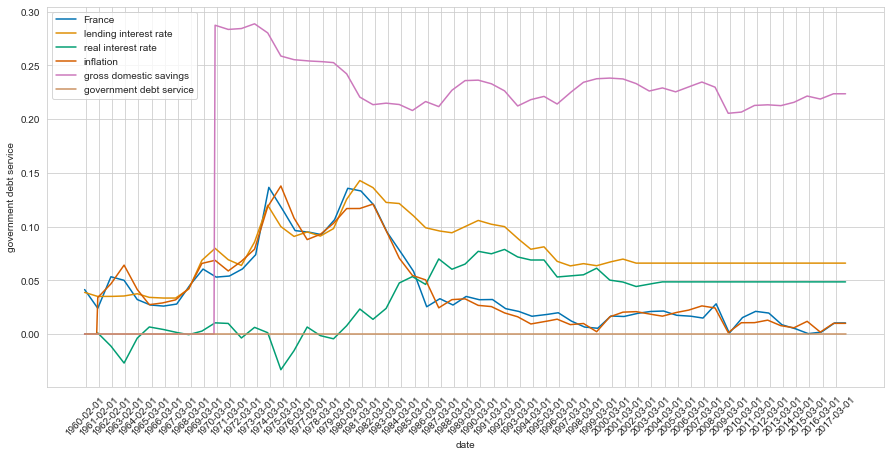

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
[sns.lineplot(x='date', y=c, markers=True, ax=ax, label=c, data=combined_df) for c in list([country, 'lending interest rate', 'real interest rate', 'inflation', 'gross domestic savings', 'government debt service'])]

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 == 1:
        xticks[i].set_visible(True)
    else:
        xticks[i].set_visible(False)

ax.set_xticklabels(combined_df['date'], rotation=45);

In [12]:
combined_df.columns

Index(['date', 'bank capital to assets ratio', 'bank nonperforming loans',
       'cereal yield', 'energy imports', 'food exports', 'high-tech exports',
       'inflation', 'lending interest rate', 'life expectancy',
       'population density', 'real interest rate', 'broad money',
       'exports of goods and services', 'gross domestic savings',
       'high-tech value added', 'household consumption expenditure',
       'imports of goods and services', 'listed companies',
       'manufacturing value added', 'r and d spend', 'services trade', 'trade',
       'government debt service', 'government interest payments external debt',
       'government tax revenue', 'birth deaths', 'broadband subscriptions',
       'electricity access', 'co2 emissions', 'electricity consumption',
       'mobile subscriptions', 'newborns', 'overweight', 'rural population',
       'urban population', 'Brazil', 'China', 'Colombia', 'France', 'Ghana',
       'India', 'Indonesia', 'Japan', 'Netherlands', 'Seneg

### Prepare the country features

In [13]:
base_feature_df = combined_df[['date', 'bank capital to assets ratio', 'bank nonperforming loans', 'cereal yield',
                               'energy imports', 'food exports', 'high-tech exports', 'inflation',
                               'lending interest rate', 'life expectancy', 'population density', 'real interest rate',
                               'broad money', 'exports of goods and services', 'gross domestic savings',
                               'high-tech value added', 'household consumption expenditure',
                               'imports of goods and services', 'listed companies', 'manufacturing value added',
                               'r and d spend', 'services trade', 'trade', 'government debt service',
                               'government interest payments external debt', 'government tax revenue', 'birth deaths',
                               'broadband subscriptions', 'electricity access', 'co2 emissions',
                               'electricity consumption', 'mobile subscriptions', 'newborns', 'overweight',
                               'rural population', 'urban population', country]]

In [14]:
base_feature_df.to_csv('features/m_one/combined_country_level_%s.csv' % country.lower(), sep=',', index=False)

In [15]:
base_feature_df['label'] = base_feature_df[country].shift(periods=1)
base_df = base_feature_df.drop(country, axis=1).fillna(0.00);
base_df.set_index('date')

,bank capital to assets ratio,bank nonperforming loans,cereal yield,energy imports,food exports,high-tech exports,inflation,lending interest rate,life expectancy,population density,...,broadband subscriptions,electricity access,co2 emissions,electricity consumption,mobile subscriptions,newborns,overweight,rural population,urban population,label
date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.0000,0.0000,0.0000,0.4282,0.0000,0.0000,0.0000,0.0387,69.8683,0.0000,...,0.0000,0.0000,5.7935,1.4567,0.0000,0.0187,0.0000,0.3812,0.6188,0.0000
1960-02-01,0.0000,0.0000,0.0000,0.4313,0.0000,0.0000,0.0000,0.0384,69.8890,0.0000,...,0.0000,0.0000,5.8046,1.4639,0.0000,0.0187,0.0000,0.3806,0.6194,0.0414
1960-03-01,0.0000,0.0000,0.0000,0.4344,0.0000,0.0000,0.0000,0.0381,69.9098,0.0000,...,0.0000,0.0000,5.8158,1.4712,0.0000,0.0187,0.0000,0.3800,0.6200,0.0399
1960-04-01,0.0000,0.0000,0.0000,0.4375,0.0000,0.0000,0.0000,0.0378,69.9305,0.0000,...,0.0000,0.0000,5.8269,1.4784,0.0000,0.0187,0.0000,0.3794,0.6206,0.0385
1960-05-01,0.0000,0.0000,0.0000,0.4406,0.0000,0.0000,0.0000,0.0375,69.9512,0.0000,...,0.0000,0.0000,5.8380,1.4857,0.0000,0.0187,0.0000,0.3788,0.6212,0.0371
1960-06-01,0.0000,0.0000,0.0000,0.4436,0.0000,0.0000,0.0000,0.0372,69.9720,0.0000,...,0.0000,0.0000,5.8492,1.4930,0.0000,0.0187,0.0000,0.3782,0.6218,0.0356
1960-07-01,0.0000,0.0000,0.0000,0.4467,0.0000,0.0000,0.0000,0.0369,69.9927,0.0000,...,0.0000,0.0000,5.8603,1.5002,0.0000,0.0187,0.0000,0.3776,0.6224,0.0342
1960-08-01,0.0000,0.0000,0.0000,0.4498,0.0000,0.0000,0.0000,0.0366,70.0134,0.0000,...,0.0000,0.0000,5.8715,1.5075,0.0000,0.0187,0.0000,0.3770,0.6230,0.0327
1960-09-01,0.0000,0.0000,0.0000,0.4529,0.0000,0.0000,0.0000,0.0362,70.0341,0.0000,...,0.0000,0.0000,5.8826,1.5147,0.0000,0.0187,0.0000,0.3764,0.6236,0.0313


In [16]:
num_obs = len(base_df)
num_cols = len(base_df.columns)
num_features = len(base_df.columns) - 1

### Model iterations
---------------------

### Exploration 0

**ARIMA** fitted on the real data.

In [17]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [18]:
ar_params = {
    'lag': 4,
    'difference': 2,
    'moving_average': 1
}

ARIMA dataprep

In [19]:
exo_cols = ['co2 emissions', 'rural population', 'electricity consumption', 'lending interest rate']

ar_endo = base_df['label'].values
ar_exo = base_df[exo_cols].values

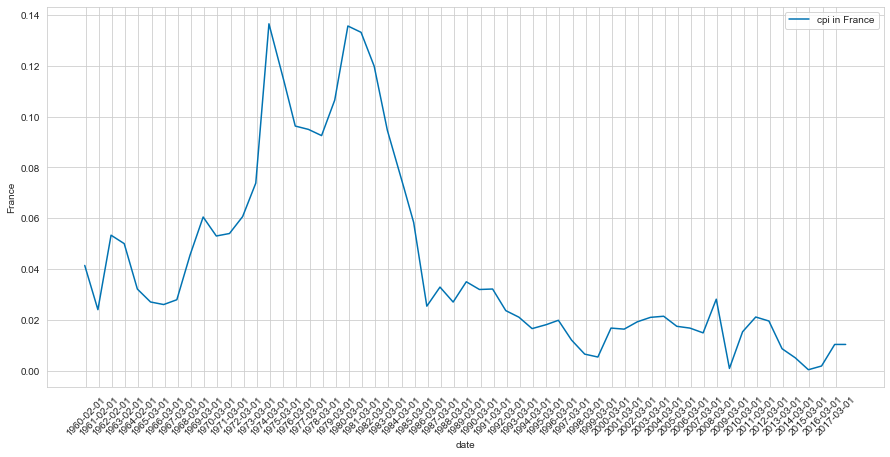

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
[sns.lineplot(x='date', y=c, markers=True, ax=ax, label='cpi in %s' % c, data=combined_df) for c in list([country])]

xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 == 1:
        xticks[i].set_visible(True)
    else:
        xticks[i].set_visible(False)

ax.set_xticklabels(combined_df['date'], rotation=45);

In [21]:
len(ar_endo)

696

In [22]:
ar_endo_train, ar_endo_test = ar_endo[0:550], ar_endo[551:696]
ar_exo_train, ar_exo_test = ar_exo[0:550], ar_exo[551:696]

In [23]:
ar_exo_test[0]

array([5.90626639, 0.22623   , 7.5402953 , 0.066     ])

Fit the ARIMA model

In [24]:
arima = ARIMA(ar_endo, order=(ar_params['lag'], ar_params['difference'], ar_params['moving_average']), exog=ar_exo)

In [25]:
arima_fitted = arima.fit()

In [26]:
arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  694
Model:                 ARIMA(4, 2, 1)   Log Likelihood                3449.951
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sun, 21 Jul 2019   AIC                          -6877.902
Time:                        14:11:50   BIC                          -6827.935
Sample:                             2   HQIC                         -6858.580
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.522      0.602      -0.002       0.003
x1             0.0002    8.2e-05      2.189      0.029    1.88e-05       0.000
x2            -0.0065      0.003     -2.213      0.027      -0.012      -0.001
x3          2.584e-05   6.71e-05      0.385      0.700      -0.000       0.000
x4            -0.0041      0.003     -1.224      0.221      -0.011       0.002
ar.L1.D2.y     0.0985        nan        nan        nan         nan         nan
ar.L2.D2.y    -0.0018      0.125     -0.014      0.989      -0.246       0.243
ar.L3.D2.y    -0.0050      0.121     -0.041      0.967      -0.242       0.232
ar.L4.D2.y     0.0001      0.127      0.001      0.999      -0.248       0.248
ma.L1.D2.y    -0.1022        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.3454           -4.3115j            5.4572           -0.1450
AR.2            3.3454           +4.3115j            5.4572            0.1450
AR.3           -6.6947           -0.0000j            6.6947           -0.5000
AR.4           43.1245           -0.0000j           43.1245           -0.0000
MA.1            9.7849           +0.0000j            9.7849            0.0000
-----------------------------------------------------------------------------
"""

#### Evaluate the ARIMA predictions

In [27]:
preds = []
obs = []
hist = [x for x in ar_endo_train]
exo_hist = [x for x in ar_exo_train]

for t in range(len(ar_endo_test)):
    m = ARIMA(hist, order=(ar_params['lag'], ar_params['difference'], ar_params['moving_average']))
    m_fit = m.fit()
    yhat = m_fit.forecast()[0][0]
    preds.append(yhat)
    hist.append(ar_endo_test[t])
    exo_hist.append(ar_exo_test[t])
    if t % 50 == 0:
        print('obs: %s, pred: %s' % (ar_endo_test[t], yhat))

obs: 0.01686915307373535, pred: 0.01685244404169789
obs: 0.0153112270420924, pred: 0.015243990063833647
obs: 0.004293847492003869, pred: 0.004229294506874988


In [28]:
predictions = list(map(lambda x: 0.00 if np.isnan(x) else x, preds))

In [29]:
mean_squared_error(ar_endo_test, predictions)

1.9842015843322444e-07

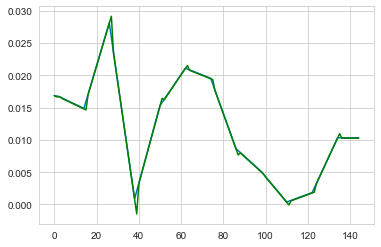

In [30]:
plt.plot(ar_endo_test)
plt.plot(preds, color='green')

### Exploration 1

**Multivariate LSTM** fitted on the real data, see https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- Activation function: Leaky ReLU.
- Loss function: mean squared error.
- Optimizer: adam.
- Num observations source dataset: 684 (using lagshift, 1960-2016 inclusive monthly)
- Num sequences (@ sequence length 6): 116.
- Batch size: 4-8 sequences (although `size=48` would lead to more stable training)

In [31]:
lstm_params = {
   'sequence_length': 4,
   'batch_size': 8,
   'num_epochs': 50,
   'num_units': 512,
   'lrelu_alpha': 0.35
}

#### LSTM features

In [32]:
lstm_df = base_df[['bank nonperforming loans', 'lending interest rate', 'real interest rate', 
                   'gross domestic savings', 'household consumption expenditure',
                   'exports of goods and services', 'imports of goods and services', 'services trade', 'trade',
                   'broad money', 'government interest payments external debt', 'government tax revenue']]

In [33]:
num_lstm_cols = len(lstm_df.columns)

In [34]:
features = []
labels = []

for i in range(int(num_obs / lstm_params['sequence_length'])):
    labels_df = base_df['label']
    labels.append(labels_df[i:(i+lstm_params['sequence_length'])].values[-1:])
    features.append(lstm_df[i:(i+lstm_params['sequence_length'])].values)

In [35]:
lstm_train_X = np.asarray(features[0:100])
lstm_train_X = lstm_train_X.reshape((lstm_train_X.shape[0], lstm_params['sequence_length'], num_lstm_cols))
lstm_train_y = np.asarray(labels[0:100])
lstm_train_y = lstm_train_y.reshape((lstm_train_y.shape[0]))

In [36]:
lstm_test_X = np.asarray(features[100:])
lstm_test_X = lstm_test_X.reshape((lstm_test_X.shape[0], lstm_params['sequence_length'], num_lstm_cols))
lstm_test_y = np.asarray(labels[100:])
lstm_test_y = lstm_test_y.reshape((lstm_test_y.shape[0]))

In [37]:
X = np.asarray(features)
X = X.reshape((X.shape[0], lstm_params['sequence_length'], num_lstm_cols))
y = np.asarray(labels)
y = y.reshape((y.shape[0], 1))

In [38]:
print('X: %s, y: %s' % (X.shape, y.shape))

X: (174, 4, 12), y: (174, 1)


#### Model: LSTM

In [39]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(lstm_params['num_units'],
                               input_shape=(lstm_params['sequence_length'], num_lstm_cols)))
model.add(tf.keras.layers.Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=lstm_params['lrelu_alpha'])))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1075200   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,075,713
Trainable params: 1,075,713
Non-trainable params: 0
_________________________________________________________________


In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=2)

In [41]:
train_run = model.fit(lstm_train_X, lstm_train_y, epochs=lstm_params['num_epochs'],
                      batch_size=lstm_params['batch_size'], callbacks=[early_stopping])

Train on 100 samples
Epoch 1/50
100/100 [==============================] - 1s 12ms/sample - loss: 4.3513e-04
Epoch 2/50
100/100 [==============================] - 0s 4ms/sample - loss: 1.2664e-04
Epoch 3/50
100/100 [==============================] - 0s 4ms/sample - loss: 8.3557e-05
Epoch 4/50
100/100 [==============================] - 0s 4ms/sample - loss: 5.8715e-05
Epoch 5/50
100/100 [==============================] - 1s 5ms/sample - loss: 4.8772e-05
Epoch 6/50
100/100 [==============================] - 0s 4ms/sample - loss: 4.4437e-05
Epoch 7/50
100/100 [==============================] - 0s 4ms/sample - loss: 4.3244e-05
Epoch 8/50
100/100 [==============================] - 0s 4ms/sample - loss: 3.2972e-05
Epoch 9/50
100/100 [==============================] - 0s 4ms/sample - loss: 3.9552e-05
Epoch 10/50
100/100 [==============================] - 0s 4ms/sample - loss: 4.5849e-05


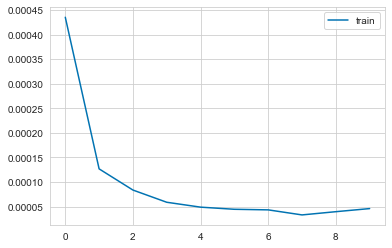

In [42]:
plt.plot(train_run.history['loss'], label='train')
plt.legend()
plt.show()

##### Evaluate model performance

In [43]:
model.evaluate(lstm_test_X, lstm_test_y)

74/74 [==============================] - 0s 5ms/sample - loss: 0.0021


0.0020528302364353395

In [44]:
yhat = model.predict(lstm_test_X)

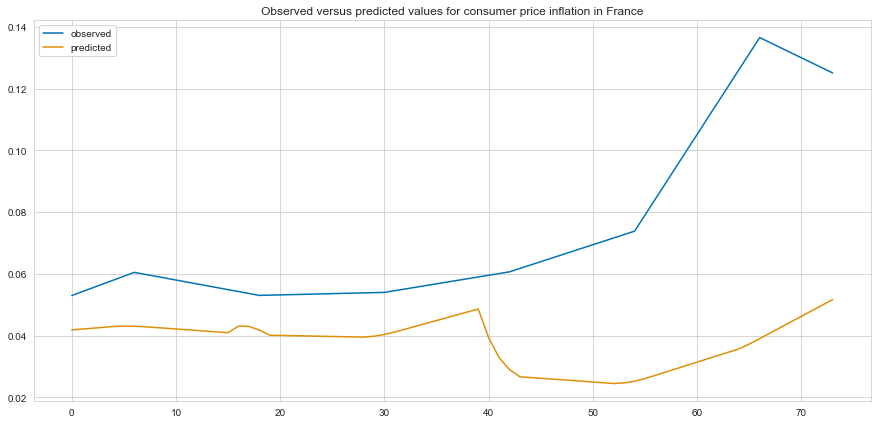

In [45]:
plt.figure(figsize=(15,7))
plt.plot(lstm_test_y, label='observed')
plt.plot(yhat, label='predicted')
plt.legend()
plt.title('Observed versus predicted values for consumer price inflation in %s' % country)
plt.show()

In [46]:
print('rmse: %s\nmean observed: %s\nmean predicted: %s' % (np.sqrt(mean_squared_error(lstm_test_y, yhat)),
                                                           np.mean(lstm_test_y), np.mean(yhat)))

rmse: 0.04530816978942868
mean observed: 0.07328627295160658
mean predicted: 0.037829693


## Exploration 2
--------------------

**GAN** to generate training data, **LSTM** trained on generated data validated on the real data.

### Conditional GAN for policy-constrained timeseries generation

See https://arxiv.org/pdf/1706.02633.pdf.

In [47]:
from keras.models import Sequential, Model
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [48]:
gan_df = base_df[['bank nonperforming loans', 'lending interest rate', 'real interest rate',
                  'gross domestic savings', 'household consumption expenditure', 'exports of goods and services',
                  'imports of goods and services', 'services trade', 'trade', 'broad money',
                  'government interest payments external debt', 'government tax revenue']]
gan_df.shape

(696, 12)

In [49]:
gan_cols = gan_df.shape[1]

In [50]:
gan_params = {
   'num_epochs': 800,
   'save_interval': 100,
   'sequence_length': 6,
   'num_variables': gan_cols,
   'batch_size': 64,
   'lr': 0.0001 
}

In [51]:
generator_params = {
   'noise_sigma': 0.3,
   'lstm_units': 128,
   'lstm_dropout': 0.4,
   'gru_units': 64,
   'lr': 0.0001
}

In [52]:
discriminator_params = {
   'bi_lstm_units': 256,
   'dropout_rate': 0.4,
   'lr': 0.0001
}

#### GAN input sequences

The collated World Bank and IMF data used as input for the data generator and to validate the model trained on generated data.

In [53]:
gan_features = []
gan_labels = []

for i in range(int(num_obs / gan_params['sequence_length'])):
    gan_labels_df = base_df['label']
    gan_labels.append(gan_labels_df[i:(i+gan_params['sequence_length'])].values[-1:])
    gan_features.append(gan_df[i:(i+gan_params['sequence_length'])].values)

In [54]:
real = np.asarray(gan_features)
real = real.reshape((real.shape[0], gan_params['sequence_length'], gan_cols))

In [55]:
real.shape

(116, 6, 12)

#### Generator

In [56]:
def build_encoder(params):
    gshape = params['sequence_length'], params['num_variables']
    inputs = tf.keras.layers.Input(shape=(gshape))
    
    e = tf.keras.models.Sequential(name='encoder')
    e.add(tf.keras.layers.LSTM(params['lstm_units'], input_shape=(gshape), return_sequences=True))
    e.add(tf.keras.layers.Dropout(params['lstm_dropout']))
    e.add(tf.keras.layers.GaussianNoise(stddev=params['noise_sigma']))
    e.add(tf.keras.layers.BatchNormalization(axis=2, momentum=0.8, epsilon=0.01))
    e.add(tf.keras.layers.Dense(params['num_variables'], activation='relu'))
    e.summary()
    
    return tf.keras.models.Model(inputs, e(inputs))

In [57]:
encoder = build_encoder({**gan_params, **generator_params})

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 128)            72192     
_________________________________________________________________
dropout (Dropout)            (None, 6, 128)            0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 6, 128)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 128)            512       
_________________________________________________________________
dense_1 (Dense)              (None, 6, 12)             1548      
Total params: 74,252
Trainable params: 73,996
Non-trainable params: 256
_________________________________________________________________


In [58]:
def build_generator(params):
    gshape = params['sequence_length'], params['num_variables']
    inputs = tf.keras.layers.Input(shape=(gshape))
    
    g = tf.keras.models.Sequential(name='generator')
    g.add(tf.keras.layers.GRU(params['gru_units'], input_shape=(gshape), return_sequences=True))
    g.add(tf.keras.layers.Dense(params['num_variables'], activation='softmax'))
    g.add(tf.keras.layers.Reshape(target_shape=(gshape)))
    g.summary()
    
    return tf.keras.models.Model(inputs, g(inputs))

In [59]:
generator = build_generator({**gan_params, **generator_params})

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 6, 64)             14976     
_________________________________________________________________
dense_2 (Dense)              (None, 6, 12)             780       
_________________________________________________________________
reshape (Reshape)            (None, 6, 12)             0         
Total params: 15,756
Trainable params: 15,756
Non-trainable params: 0
_________________________________________________________________


#### Discriminator

In [60]:
def build_discriminator(params):
    dshape = params['sequence_length'], params['num_variables']
    batch_shape = params['batch_size'], params['sequence_length'], params['num_variables']
    
    real = tf.keras.layers.Input(shape=(dshape))
    generated = tf.keras.layers.Input(shape=(dshape))
    inputs = tf.keras.layers.concatenate([generated, real], axis=1)
    
    d = tf.keras.models.Sequential(name='discriminator')
    d.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(params['bi_lstm_units']), batch_input_shape=(batch_shape)))
    d.add(tf.keras.layers.Dropout(params['dropout_rate']))
    d.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    d.summary()
    return tf.keras.models.Model([generated, real], d(inputs))

In [61]:
discriminator = build_discriminator({**gan_params, **discriminator_params})
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(lr=discriminator_params['lr']), metrics=['accuracy'])

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (64, 512)                 550912    
_________________________________________________________________
dropout_1 (Dropout)          (64, 512)                 0         
_________________________________________________________________
dense_3 (Dense)              (64, 1)                   513       
Total params: 551,425
Trainable params: 551,425
Non-trainable params: 0
_________________________________________________________________


#### GAN

Bidirectional generative adversarial network, viz https://arxiv.org/abs/1605.09782.

In [62]:
def build_gan(encoder, generator, discriminator, params):
    ganshape = params['sequence_length'], params['num_variables']
    discriminator.trainable = False
    
    noise = tf.keras.layers.Input(shape=(ganshape))
    generated = generator(noise)
    
    data = tf.keras.layers.Input(shape=(ganshape))
    encoded = encoder(data)
    
    fake = discriminator([noise, generated])
    real = discriminator([encoded, data])
    
    gan = tf.keras.models.Model([noise, data], [fake, real], name='gan')
    gan.summary()
    return gan

In [63]:
gan = build_gan(encoder, generator, discriminator, gan_params)
gan.compile(loss=['kullback_leibler_divergence', 'kullback_leibler_divergence'], 
            optimizer=tf.keras.optimizers.Adam(lr=generator_params['lr']), metrics=['mse', 'mse'])

Model: "gan"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6, 12)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 6, 12)]      0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 6, 12)        15756       input_5[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 6, 12)        74252       input_6[0][0]                    
________________________________________________________________________________________________

In [64]:
def train_gan(real, batch_size, params):
    g_metrics = []
    d_real_metrics = []
    d_synth_metrics = []
    
    reals = np.ones(batch_size)
    synths = np.zeros(batch_size)
    
    for i in range(params['num_epochs']):
        # create input of real and synthetic data
        random_index = np.random.randint(0, len(real) - batch_size)
        half_real = real[random_index:int(random_index + batch_size)]
        half_synth = np.random.normal(-1.0, 1.0, size=[batch_size, params['sequence_length'], real.shape[2]])
        
        # apply generator and encoder
        generated = generator.predict(half_synth)
        encoded = encoder.predict(half_real)
        
        # train discriminator
        d_real = discriminator.train_on_batch([encoded, half_real], reals)
        d_synth = discriminator.train_on_batch([half_synth, generated], synths)
                                                            
        # train gan
        gen_ = gan.train_on_batch([generated, encoded], [reals, synths])
        if i % 100 == 0:
            print('Epoch %s losses: discriminator real: %.4f%%, discriminator synth: %.4f%%, generator: %.4f%%' % 
                  (i, d_real[0], d_synth[0], gen_[0]))
        
        d_real_metrics.append(d_real)
        d_synth_metrics.append(d_synth)
        g_metrics.append(gen_)
    return d_real_metrics, d_synth_metrics, g_metrics

In [65]:
d_r_metrics, d_s_metrics, g_metrics = train_gan(real, gan_params['batch_size'], gan_params)

W0721 14:13:11.675553 4759352768 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
W0721 14:13:11.839902 4759352768 deprecation.py:323] From /Users/braadbaart/pysphere/me/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0721 14:13:15.341199 4759352768 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Epoch 0 losses: discriminator real: 0.6996%, discriminator synth: 0.7087%, generator: 0.6869%
Epoch 100 losses: discriminator real: 0.0015%, discriminator synth: 0.0008%, generator: 0.0007%
Epoch 200 losses: discriminator real: 0.0003%, discriminator synth: 0.0001%, generator: 0.0002%
Epoch 300 losses: discriminator real: 0.0001%, discriminator synth: 0.0001%, generator: 0.0001%
Epoch 400 losses: discriminator real: 0.0001%, discriminator synth: 0.0000%, generator: 0.0000%
Epoch 500 losses: discriminator real: 0.0001%, discriminator synth: 0.0000%, generator: 0.0000%
Epoch 600 losses: discriminator real: 0.0001%, discriminator synth: 0.0000%, generator: 0.0000%
Epoch 700 losses: discriminator real: 0.0000%, discriminator synth: 0.0000%, generator: 0.0000%


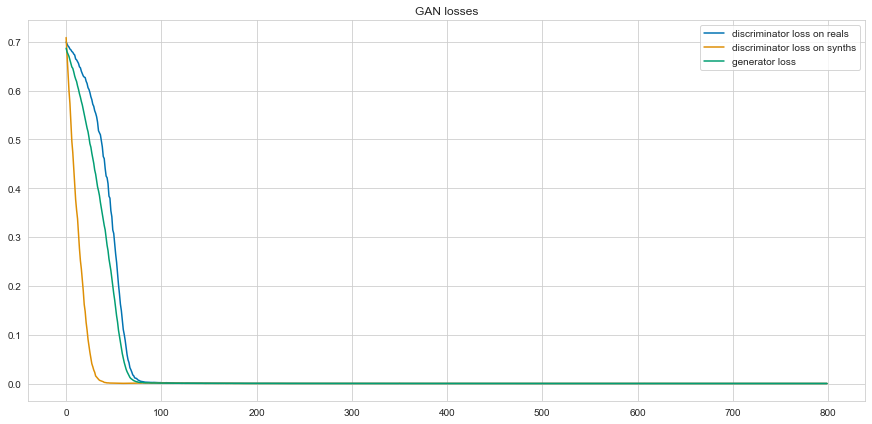

In [66]:
plt.figure(figsize=(15,7))
plt.plot([metrics[0] for metrics in d_r_metrics], label='discriminator loss on reals')
plt.plot([metrics[0] for metrics in d_s_metrics], label='discriminator loss on synths')
plt.plot([metrics[0] for metrics in g_metrics], label='generator loss')
plt.legend()
plt.title('GAN losses')
plt.show()

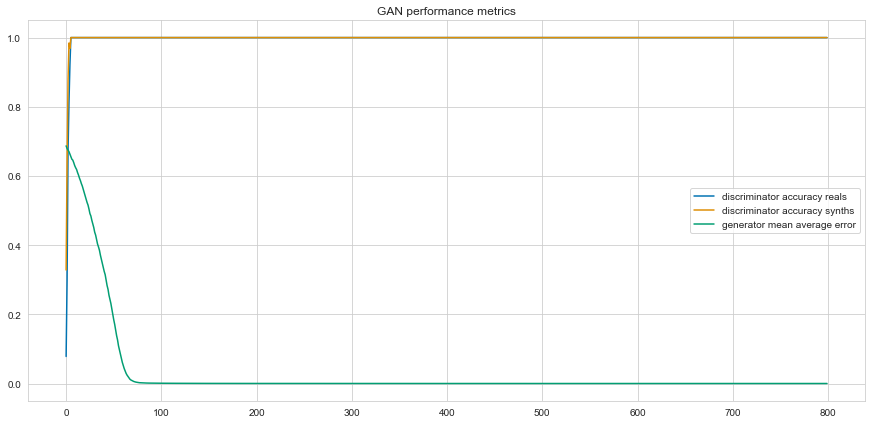

In [67]:
plt.figure(figsize=(15,7))
plt.plot([metrics[1] for metrics in d_r_metrics], label='discriminator accuracy reals')
plt.plot([metrics[1] for metrics in d_s_metrics], label='discriminator accuracy synths')
plt.plot([metrics[1] for metrics in g_metrics], label='generator mean average error')
plt.legend()
plt.title('GAN performance metrics')
plt.show()

In [68]:
generated_y = generator.predict(np.random.rand(num_obs, gan_params['sequence_length'], gan_cols))[:,-1,-1]
gan_y = base_df['label'].values

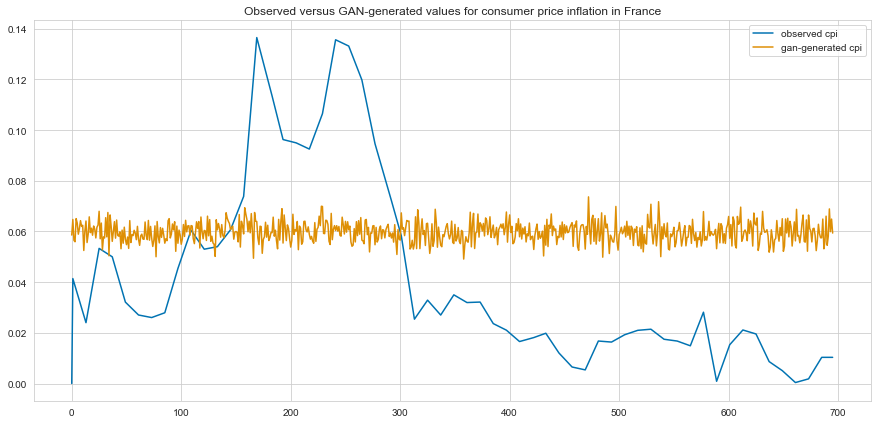

In [69]:
plt.figure(figsize=(15,7))
plt.plot(gan_y, label='observed cpi')
plt.plot(generated_y, label='gan-generated cpi')
plt.legend()
plt.title('Observed versus GAN-generated values for consumer price inflation in %s' % country)
plt.show()

In [70]:
print('rmse: %s\nmean observed: %s\nmean generated: %s' % (np.sqrt(mean_squared_error(gan_y, generated_y)),
                                                           np.mean(gan_y), np.mean(generated_y)))

rmse: 0.040645608098520865
mean observed: 0.04203555603346822
mean generated: 0.059723634


## Exploration 3
--------------------

**Sequence transformer network** to generate training data, **LSTM** trained on generated data validated on the real data. See https://arxiv.org/abs/1808.06725